In [7]:
import os
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from facenet_pytorch import InceptionResnetV1
import random
from PIL import Image
import torch.nn.functional as F
import heapq
import numpy as np
# import matplotlib.pyplot as plt
from collections import Counter

In [2]:
class TripletDataset(Dataset):
    def __init__(self, root_dir, transform=None, has_faces_label=True):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.labels = []
        self.has_faces_label = has_faces_label
        
        individuals = os.listdir(root_dir)
        self.class_to_idx = {ind: i for i, ind in enumerate(individuals)} #lie les individus (AD, BS, ...) à un ID
        
        #Pour chaque individu, on prend chaque image et le label correspondant et on les ajoute dans les attributs de classe
        for ind in individuals:
            if self.has_faces_label:
                img_dir =f"{root_dir}/{ind}/images"
                label_dir = f"{root_dir}/{ind}/labels"
            else: 
                img_dir =f"{root_dir}/{ind}"
            if os.path.exists(img_dir): #and os.path.exists(label_dir):
                for img_name in os.listdir(img_dir):
                    img_path = os.path.join(img_dir, img_name)
                    image = Image.open(img_path).convert("RGB")
                    if self.has_faces_label: 
                        label_name = img_name.replace(".png", ".txt")
                        label_name = label_name.replace(".jpg", ".txt")
                        label_name = label_name.replace(".JPG", ".txt")
                        label_path = os.path.join(label_dir, label_name)
                        bbox = self.read_yolo_label(label_path, image.width, image.height)
                        image = image.crop(bbox)
                    self.data.append(image)
                    self.labels.append(self.class_to_idx[ind])
        
        self.labels = torch.tensor(self.labels)

    def __len__(self):
        return len(self.data)

    def read_yolo_label(self, label_path, img_width, img_height):
        with open(label_path, "r") as f:
            lines = f.readlines()
        if not lines:
            return None  # Pas de bounding box trouvée
        
        #On récupère la bbox du visage et pas celle du corps
        face_annotation = None
        for line in lines: 
            if line[0] == "0":  #0 est le label des annotations des visages
                face_annotation = line
        _, x_center, y_center, width, height = map(float, face_annotation.split())
        
        # Conversion des coordonnées normalisées en pixels
        x_center *= img_width
        y_center *= img_height
        width *= img_width
        height *= img_height
        
        x1 = int(x_center - width / 2)
        y1 = int(y_center - height / 2)
        x2 = int(x_center + width / 2)
        y2 = int(y_center + height / 2)
        
        return (x1, y1, x2, y2)
    
    def get_embedding(model, img_tensor):
        with torch.no_grad():
            embedding = model(img_tensor)
        return F.normalize(embedding, p=2, dim=1)  # Normalisation L2
    
    def compute_embeddings(self, model, device, transform):
        self.embeddings = []
        self.embedding_indices = []

        model.eval()
        with torch.no_grad():
            for idx in range(len(self.data)):
                if self.has_faces_label:
                    img_path, label_path = self.data[idx]
                    img = Image.open(img_path).convert("RGB")
                    bbox = self.read_yolo_label(label_path, img.width, img.height)
                    if bbox:
                        img = img.crop(bbox)
                    else:
                        continue  # Skip images sans visage détecté
                else:
                    img_path = self.data[idx]
                    img = Image.open(img_path).convert("RGB")
                    
                img_tensor = transform(img).unsqueeze(0).to(device)
                embedding = self.get_embedding(model, img_tensor).squeeze(0).cpu()  #cpu ramnène l'embedding sur le cpu pour éviter de futures erreurs 
                self.embeddings.append(embedding)
                self.embedding_indices.append(idx)
            
        self.embeddings = torch.stack(self.embeddings)


    def get_semi_difficult_pair(self, idx, margin=1.0):
        anchor_embedding = self.embeddings[idx]
        anchor_label = self.labels[idx]

        positive_indices = torch.where(self.labels == anchor_label)[0]
        negative_indices = torch.where(self.labels != anchor_label)[0]

        # On ignore l'anchor elle-même
        positive_indices = positive_indices[positive_indices != idx]

        pos_dists = torch.norm(self.embeddings[positive_indices] - anchor_embedding, dim=1)
        neg_dists = torch.norm(self.embeddings[negative_indices] - anchor_embedding, dim=1)

        # Semi-hard: positives pas trop proches, négatifs pas trop loin
        semi_hard_positives = positive_indices[(pos_dists > 0.3) & (pos_dists < 0.8)]
        semi_hard_negatives = negative_indices[neg_dists < pos_dists.min() + margin]

        if len(semi_hard_positives) == 0:
            semi_hard_positives = positive_indices
        if len(semi_hard_negatives) == 0:
            semi_hard_negatives = negative_indices

        pos_idx = random.choice(semi_hard_positives.tolist())
        neg_idx = random.choice(semi_hard_negatives.tolist())
        
        return pos_idx, neg_idx


    def __getitem__(self, idx):
        anchor_label = self.labels[idx]

        positive_indices = torch.where(self.labels == anchor_label)[0]
        negative_indices = torch.where(self.labels != anchor_label)[0]
        
        positive_idx = random.choice(positive_indices)
        negative_idx = random.choice(negative_indices)
        #Pour faire de la meilleure triplet selection mais fonctionne pas pour l'instant -> trouver comment mettre à jour les embedding à chaque epoch
        #positive_idx, negative_idx = self.get_semi_difficult_pair(idx) 
        anchor_image = self.data[idx]
        pos_image = self.data[positive_idx]
        neg_image = self.data[negative_idx]
        if self.transform:
            anchor_img = self.transform(anchor_image)
            positive_img = self.transform(pos_image)
            negative_img = self.transform(neg_image)
        
        return anchor_img, positive_img, negative_img

In [3]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, save_model_file, num_epochs=10, patience=3):
    model.to(device)
    criterion.to(device)
    
    best_val_loss = float("inf")
    best_model_state = None 
    epochs_without_improvement = 0

    for epoch in range(num_epochs):
        #Idéer pour quand on fera une meilleure triplet selection mais fonctionne pas pour l'instant
        #train_dataset.compute_embeddings(facenet, device)
        #val_dataset.compute_embeddings(facenet, device)

        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        print("-----------------------")
        
        model.train() #mets le modèle en mode entrainement (modèle màj ses poids en fonction des gradients)
        running_loss = 0.0
        
        # Pour chaque mini-batch, on calcule les embedding, la loss et on màj les poids en fonction
        for anchor, positive, negative in train_loader:
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
            optimizer.zero_grad() #réinitialise les gradinets car .backward() les accumule
            
            #calcule les embeddings
            anchor_output = model(anchor)
            positive_output = model(positive)
            negative_output = model(negative)

            #calcule la loss en fonction des embeddings
            loss = criterion(anchor_output, positive_output, negative_output)
            loss.backward() #calcule le gradient de la loss grâce à la back propagation
            optimizer.step() #màj les poids du modèle

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        print(f"Train Loss: {epoch_loss:.4f}")

        # Calcule la loss sur le validation set
        model.eval() #mets le modèle en mode evaluation: les poids sont figés (+Batch Normalization et Dropout, fonctionnent différemment)
        val_loss = 0.0
        with torch.no_grad():
            for anchor, positive, negative in val_loader:
                anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
                
                anchor_output = model(anchor)
                positive_output = model(positive)
                negative_output = model(negative)
                
                loss = criterion(anchor_output, positive_output, negative_output)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        print(f"Val Loss: {val_loss:.4f}")

        #Si le score ne s'est pas amélioré depuis un certains nombres d'epcoh, on stoppe plus tôt l'entrainement 
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            print(f"Early stopping: {epochs_without_improvement}/{patience}")

            if epochs_without_improvement >= patience:
                print("Early stopping déclenché. Arrêt de l'entraînement.")
                break
    if best_model_state:
        model.load_state_dict(best_model_state)
        torch.save(best_model_state, save_model_file)

In [4]:
def create_model(dataset_path, model_file, transform, nb_layer_fine_tune, has_faces_label, learning_rate=0.001, nb_epoch=100, patience=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    facenet = InceptionResnetV1(pretrained='vggface2').eval()
    facenet = facenet.to(device)

    for param in facenet.parameters():
        param.requires_grad = False

    for layer in list(facenet.children())[-nb_layer_fine_tune:]:
        for param in layer.parameters():
            param.requires_grad = True

    train_dataset = TripletDataset(f"{dataset_path}/train", transform=transform, has_faces_label=has_faces_label)
    val_dataset = TripletDataset(f"{dataset_path}/val", transform=transform, has_faces_label=has_faces_label)

    #DataLoader facilite le chargement, le traitement et la gestion des données lors de l'entraînement et l'évaluation d'un modèle
    #permet de diviser un dataset en mini-batches, d'appliquer du shuffling et de paralléliser
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0, pin_memory=True)

    criterion = nn.TripletMarginLoss(margin=1.0)
    #filter permet de directement dire à l'optimizer quelle couche sont dégelée
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, facenet.parameters()), lr=learning_rate)
    
    train_model(facenet, train_loader, val_loader, criterion, optimizer, device, model_file, num_epochs=nb_epoch, patience=patience)


Training of the different models for ChimpRec:

In [ ]:
dataset_path = "C:/Users/julie/OneDrive - UCL/Master_2/Mémoire/Chimprec Dataset/ChimpRec Recognition/Preprocess"

# Définition des transformations pour les images
transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

layers_to_test = [5,7,9,10,11,12,13,14,15]

for nb_layer in layers_to_test: 
    model_file = f"C:/Users/julie/OneDrive - UCL/Master_2/Mémoire/ChimpRec/Code/recognition/FaceNet/Models/ChimpRec_triplet_loss/facenet_{nb_layer}_layers_triplet_loss.pth"
    create_model(dataset_path, model_file, transform, nb_layer, True)


Epoch 1/100
-----------------------
Train Loss: 0.8330
Val Loss: 0.7623

Epoch 2/100
-----------------------
Train Loss: 0.7334
Val Loss: 0.6571

Epoch 3/100
-----------------------
Train Loss: 0.6949
Val Loss: 0.6482

Epoch 4/100
-----------------------
Train Loss: 0.6253
Val Loss: 0.6126

Epoch 5/100
-----------------------
Train Loss: 0.5946
Val Loss: 0.6121

Epoch 6/100
-----------------------
Train Loss: 0.5890
Val Loss: 0.5737

Epoch 7/100
-----------------------
Train Loss: 0.5727
Val Loss: 0.4873

Epoch 8/100
-----------------------
Train Loss: 0.5342
Val Loss: 0.5458
Early stopping: 1/10

Epoch 9/100
-----------------------
Train Loss: 0.5358
Val Loss: 0.5552
Early stopping: 2/10

Epoch 10/100
-----------------------
Train Loss: 0.5483
Val Loss: 0.4274

Epoch 11/100
-----------------------
Train Loss: 0.5450
Val Loss: 0.5731
Early stopping: 1/10

Epoch 12/100
-----------------------
Train Loss: 0.5154
Val Loss: 0.5467
Early stopping: 2/10

Epoch 13/100
-----------------------

Training of the different models for CCR:

In [ ]:
dataset_path = "C:/Users/julie/Documents/Unif/Mémoire/CCR_recognition_dataset"

# Définition des transformations pour les images
transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

layers_to_test = [5,7,9,10,11,12,13,14,15]

for nb_layer in layers_to_test: 
    model_file = f"C:/Users/julie/OneDrive - UCL/Master_2/Mémoire/ChimpRec/Code/recognition/FaceNet/Models/CCR_triplet_loss/facenet_{nb_layer}_layers_triplet_loss.pth"
    create_model(dataset_path, model_file, transform, nb_layer, False)

To predict new faces:

In [5]:
# Fonction pour obtenir l'embedding de l'image
def get_embedding(model, img_tensor):
    with torch.no_grad():
        embedding = model(img_tensor)
    return F.normalize(embedding, p=2, dim=1)  # Normalisation L2

def read_yolo_label(label_path, img_width, img_height):
        with open(label_path, "r") as f:
            lines = f.readlines()
        if not lines:
            return None  # Pas de bounding box trouvée
        
        #On récupère la bbox du visage et pas celle du corps
        face_annotation = None
        for line in lines: 
            if line[0] == "0":  #0 est le label des annotations des visages
                face_annotation = line
        _, x_center, y_center, width, height = map(float, face_annotation.split())
        
        # Conversion des coordonnées normalisées en pixels
        x_center *= img_width
        y_center *= img_height
        width *= img_width
        height *= img_height
        
        x1 = int(x_center - width / 2)
        y1 = int(y_center - height / 2)
        x2 = int(x_center + width / 2)
        y2 = int(y_center + height / 2)
        
        return (x1, y1, x2, y2)

def get_all_embeddings(dataset, model, device, has_face_label=True):
    all_embeddings = {}
    for indiv in os.listdir(dataset): 
        all_embeddings[indiv] = []
        if has_face_label:
            images_path = f"{dataset}/{indiv}/images"
        else:
            images_path = f"{dataset}/{indiv}"
        indiv_embeddings = []
        for img in os.listdir(images_path):
            if has_face_label:
                label_name = img.replace(".png", ".txt")
                label_name = label_name.replace(".jpg", ".txt")
                label_name = label_name.replace(".JPG", ".txt")
                label_path = os.path.join(f"{dataset}/{indiv}/labels", label_name)
                img_path = f"{dataset}/{indiv}/images/{img}"
                image = Image.open(img_path).convert("RGB")
                bbox = read_yolo_label(label_path, image.width, image.height)
                image = image.crop(bbox) 
            else: 
                img_path = f"{dataset}/{indiv}/{img}"
                image = Image.open(img_path).convert("RGB")
            
            img_tensor = transform(image).unsqueeze(0).to(device)
            embedding = get_embedding(model, img_tensor)
            indiv_embeddings.append(embedding)
        all_embeddings[indiv] = indiv_embeddings
    return all_embeddings

def get_most_predicted_class(labels, class_to_idx): 
    counter = {}
    for label in labels: 
        if label in counter.keys(): 
            counter[label] = counter[label] + 1
        else: 
            counter[label] = 1
    return max(counter, key=counter.get)


def compare_embeddings(input_embedding, all_embeddings, k, class_to_idx):
    distances = []  # Stocke (distance, label, image recadrée)
    for individual in all_embeddings.keys(): 
        for embedding in all_embeddings[individual]: 
            distance = F.pairwise_distance(input_embedding, embedding).item()
            distances.append((distance, individual))

    # Trouver les k plus proches voisins
    k_nearest = heapq.nsmallest(k, distances, key=lambda x: x[0])  # Trier par distance croissante

    # Récupérer les labels des k voisins
    k_labels = [label for _, label in k_nearest]

    # Trouver la classe majoritaire
    predicted_label = get_most_predicted_class(k_labels, class_to_idx)

    return predicted_label

def predict_face(img, facenet, all_embeddings, device, transform, k, class_to_idx): 

    img_tensor = transform(img).unsqueeze(0).to(device)  # Ajouter une dimension batch et déplacer sur GPU/CPU
    input_embedding = get_embedding(facenet, img_tensor)

    # Comparer l'embedding de l'image d'entrée avec ceux du dataset
    return compare_embeddings(input_embedding, all_embeddings, k, class_to_idx)

Graph for ChimpRec:

In [6]:
dataset_path = "C:/Users/julie/OneDrive - UCL/Master_2/Mémoire/Chimprec Dataset/ChimpRec Recognition/Preprocess"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
layers_to_test = [5,6,7,8,9,10,11,12,13,14,15,16,17,18]

# Transforms
transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

test_dataset = "C:/Users/julie/OneDrive - UCL/Master_2/Mémoire/Chimprec Dataset/ChimpRec Recognition/Test_set"
train_dataset = f"{dataset_path}/train"
val_dataset = f"{dataset_path}/val"
imgs = os.listdir(test_dataset)

train_triplet_dataset = TripletDataset(train_dataset, transform=transform)
class_names = list(train_triplet_dataset.class_to_idx.keys())

precisions_per_model = {}
for layer in layers_to_test: 
    model_path = f"C:/Users/julie/OneDrive - UCL/Master_2/Mémoire/ChimpRec/Code/recognition/FaceNet/Models/ChimpRec_triplet_loss/facenet_{layer}_layers_triplet_loss.pth"
    facenet = InceptionResnetV1(pretrained='vggface2').eval()
    facenet.load_state_dict(torch.load(model_path, map_location=device))
    facenet = facenet.to(device)
    facenet.eval()

    #On calcule les embeddings du train dataset et on test sur les images du validation pour trouver la valeur opti des hyperparam
    all_embeddings = get_all_embeddings(train_dataset, facenet, device)
    precisions_per_k = {}
    for k in [1,3,5]: 
        correctly_classified = 0
        total_img = 0
        for indiv in os.listdir(val_dataset): 
            for img in os.listdir(f"{val_dataset}/{indiv}/images"):
                total_img += 1
                img_path = f"{val_dataset}/{indiv}/images/{img}" 
                label_name = img.replace(".png", ".txt")
                label_name = label_name.replace(".jpg", ".txt")
                label_name = label_name.replace(".JPG", ".txt")
                label_path = os.path.join(f"{val_dataset}/{indiv}/labels", label_name)
                image = Image.open(img_path).convert("RGB")
                bbox = read_yolo_label(label_path, image.width, image.height)
                image = image.crop(bbox)
                predicted_label = predict_face(image, facenet, all_embeddings, device, transform, k, class_names)
                if predicted_label == indiv: 
                    correctly_classified += 1
        precisions_per_k[k] = (correctly_classified/total_img)
    precisions_per_model[layer] = precisions_per_k

print(precisions_per_model)

{5: {1: 0.7533039647577092, 3: 0.7180616740088106, 5: 0.7136563876651982}, 6: {1: 0.8810572687224669, 3: 0.8854625550660793, 5: 0.8854625550660793}, 7: {1: 0.8193832599118943, 3: 0.7929515418502202, 5: 0.8193832599118943}, 8: {1: 0.8546255506607929, 3: 0.8502202643171806, 5: 0.8414096916299559}, 9: {1: 0.8193832599118943, 3: 0.8193832599118943, 5: 0.8237885462555066}, 10: {1: 0.7048458149779736, 3: 0.7092511013215859, 5: 0.7136563876651982}, 11: {1: 0.8061674008810573, 3: 0.8105726872246696, 5: 0.801762114537445}, 12: {1: 0.8986784140969163, 3: 0.8722466960352423, 5: 0.8766519823788547}, 13: {1: 0.8810572687224669, 3: 0.8898678414096917, 5: 0.8898678414096917}, 14: {1: 0.8061674008810573, 3: 0.8105726872246696, 5: 0.8193832599118943}, 15: {1: 0.8634361233480177, 3: 0.8502202643171806, 5: 0.8590308370044053}, 16: {1: 0.9118942731277533, 3: 0.9030837004405287, 5: 0.8898678414096917}, 17: {1: 0.7577092511013216, 3: 0.7444933920704846, 5: 0.7577092511013216}, 18: {1: 0.8414096916299559, 3:

Graph for CCR:

In [7]:
dataset_path = "C:/Users/julie/Documents/Unif/Mémoire/CCR_recognition_dataset"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
layers_to_test = [5,6,7,8,9,10,11,12,13,14,15,16,17,18]

# Transforms
transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

test_dataset = f"{dataset_path}/test"
val_dataset = f"{dataset_path}/val"
train_dataset = f"{dataset_path}/train"

train_triplet_dataset = TripletDataset(train_dataset, transform=transform)
class_names = list(train_triplet_dataset.class_to_idx.keys())

precisions_per_model = {}
for layer in layers_to_test: 
    model_path = f"C:/Users/julie/OneDrive - UCL/Master_2/Mémoire/ChimpRec/Code/recognition/FaceNet/Models/CCR_triplet_loss/facenet_{layer}_layers_triplet_loss.pth"
    facenet = InceptionResnetV1(pretrained='vggface2').eval()
    facenet.load_state_dict(torch.load(model_path, map_location=device))
    facenet = facenet.to(device)
    facenet.eval()

    #On calcule les embeddings du train dataset et on test sur les images du validation pour trouver la valeur opti des hyperparam
    all_embeddings = get_all_embeddings(train_dataset, facenet, device, False)
    precisions_per_k = {}
    for k in [1,3,5]: 
        correctly_classified = 0
        total_img = 0
        for indiv in os.listdir(val_dataset): 
            for img in os.listdir(f"{val_dataset}/{indiv}"):
                total_img += 1
                img_path = f"{val_dataset}/{indiv}/{img}" 
                image = Image.open(img_path).convert("RGB")
                predicted_label = predict_face(image, facenet, all_embeddings, device, transform, k, class_names)
                if predicted_label == indiv: 
                    correctly_classified += 1
        precisions_per_k[k] = (correctly_classified/total_img)
    precisions_per_model[layer] = precisions_per_k

print(precisions_per_model)

{5: {1: 0.296, 3: 0.3028, 5: 0.3116}, 6: {1: 0.4876, 3: 0.5016, 5: 0.5088}, 7: {1: 0.4252, 3: 0.4424, 5: 0.4452}, 8: {1: 0.6112, 3: 0.6108, 5: 0.6152}, 9: {1: 0.4064, 3: 0.4104, 5: 0.4224}, 10: {1: 0.3344, 3: 0.3484, 5: 0.3548}, 11: {1: 0.5004, 3: 0.5068, 5: 0.5016}, 12: {1: 0.5428, 3: 0.542, 5: 0.5416}, 13: {1: 0.636, 3: 0.632, 5: 0.6332}, 14: {1: 0.5276, 3: 0.5352, 5: 0.5352}, 15: {1: 0.52, 3: 0.5236, 5: 0.5192}, 16: {1: 0.5096, 3: 0.5176, 5: 0.5276}, 17: {1: 0.4068, 3: 0.4188, 5: 0.42}, 18: {1: 0.4576, 3: 0.4596, 5: 0.4604}}


Graphs:

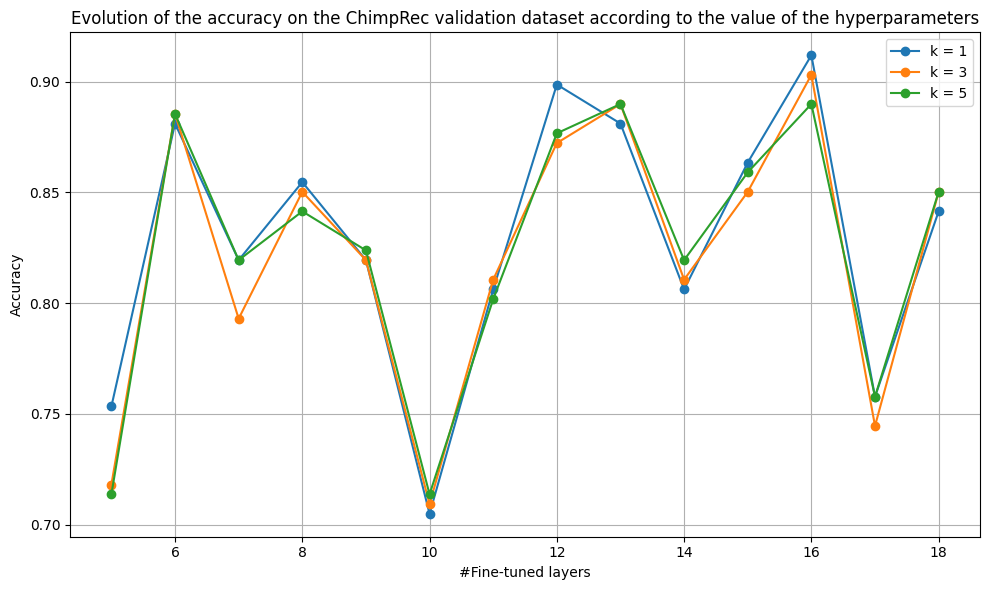

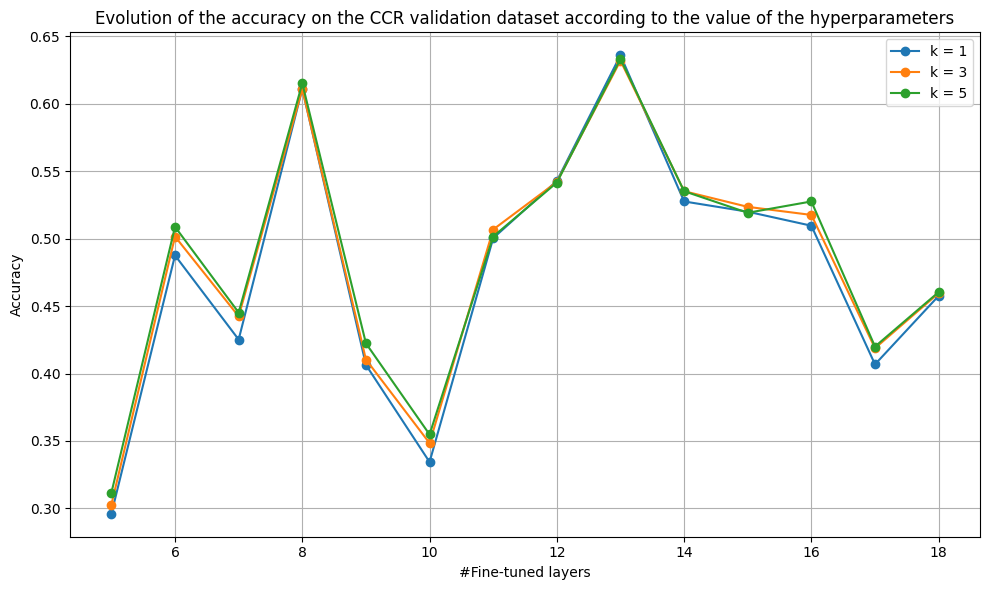

In [2]:
chimprec = {5: {1: 0.7533039647577092, 3: 0.7180616740088106, 5: 0.7136563876651982}, 6: {1: 0.8810572687224669, 3: 0.8854625550660793, 5: 0.8854625550660793}, 7: {1: 0.8193832599118943, 3: 0.7929515418502202, 5: 0.8193832599118943}, 8: {1: 0.8546255506607929, 3: 0.8502202643171806, 5: 0.8414096916299559}, 9: {1: 0.8193832599118943, 3: 0.8193832599118943, 5: 0.8237885462555066}, 10: {1: 0.7048458149779736, 3: 0.7092511013215859, 5: 0.7136563876651982}, 11: {1: 0.8061674008810573, 3: 0.8105726872246696, 5: 0.801762114537445}, 12: {1: 0.8986784140969163, 3: 0.8722466960352423, 5: 0.8766519823788547}, 13: {1: 0.8810572687224669, 3: 0.8898678414096917, 5: 0.8898678414096917}, 14: {1: 0.8061674008810573, 3: 0.8105726872246696, 5: 0.8193832599118943}, 15: {1: 0.8634361233480177, 3: 0.8502202643171806, 5: 0.8590308370044053}, 16: {1: 0.9118942731277533, 3: 0.9030837004405287, 5: 0.8898678414096917}, 17: {1: 0.7577092511013216, 3: 0.7444933920704846, 5: 0.7577092511013216}, 18: {1: 0.8414096916299559, 3: 0.8502202643171806, 5: 0.8502202643171806}}

layers = list(chimprec.keys())
k_values = [1, 3, 5]

plt.figure(figsize=(10, 6))

for k in k_values:
    values = [chimprec[layer][k] for layer in layers]
    plt.plot(layers, values, marker='o', label=f'k = {k}')

plt.xlabel('#Fine-tuned layers')
plt.ylabel('Accuracy')
plt.title('Evolution of the accuracy on the ChimpRec validation dataset according to the value of the hyperparameters')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("fine_tuning_ChimpRec_triplet_loss.svg")
plt.show()



ccr = {5: {1: 0.296, 3: 0.3028, 5: 0.3116}, 6: {1: 0.4876, 3: 0.5016, 5: 0.5088}, 7: {1: 0.4252, 3: 0.4424, 5: 0.4452}, 8: {1: 0.6112, 3: 0.6108, 5: 0.6152}, 9: {1: 0.4064, 3: 0.4104, 5: 0.4224}, 10: {1: 0.3344, 3: 0.3484, 5: 0.3548}, 11: {1: 0.5004, 3: 0.5068, 5: 0.5016}, 12: {1: 0.5428, 3: 0.542, 5: 0.5416}, 13: {1: 0.636, 3: 0.632, 5: 0.6332}, 14: {1: 0.5276, 3: 0.5352, 5: 0.5352}, 15: {1: 0.52, 3: 0.5236, 5: 0.5192}, 16: {1: 0.5096, 3: 0.5176, 5: 0.5276}, 17: {1: 0.4068, 3: 0.4188, 5: 0.42}, 18: {1: 0.4576, 3: 0.4596, 5: 0.4604}}

layers = list(ccr.keys())
k_values = [1, 3, 5]

plt.figure(figsize=(10, 6))

for k in k_values:
    values = [ccr[layer][k] for layer in layers]
    plt.plot(layers, values, marker='o', label=f'k = {k}')

plt.xlabel('#Fine-tuned layers')
plt.ylabel('Accuracy')
plt.title('Evolution of the accuracy on the CCR validation dataset according to the value of the hyperparameters')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("fine_tuning_CCR_triplet_loss.svg")
plt.show()

Evaluation on the test set for ChimpRec: 

In [ ]:
dataset_path = "C:/Users/julie/OneDrive - UCL/Master_2/Mémoire/Chimprec Dataset/ChimpRec Recognition/Preprocess"
test_dataset = "C:/Users/julie/OneDrive - UCL/Master_2/Mémoire/Chimprec Dataset/ChimpRec Recognition/Test_set"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transforms
transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

train_dataset = f"{dataset_path}/train"
val_dataset = f"{dataset_path}/val"

train_triplet_dataset = TripletDataset(train_dataset, transform=transform)
class_names = list(train_triplet_dataset.class_to_idx.keys())

model_path = f"C:/Users/julie/OneDrive - UCL/Master_2/Mémoire/ChimpRec/Code/recognition/FaceNet/Models/ChimpRec_triplet_loss/facenet_16_layers_triplet_loss.pth"
facenet = InceptionResnetV1(pretrained='vggface2').eval()
facenet.load_state_dict(torch.load(model_path, map_location=device))
facenet = facenet.to(device)
facenet.eval()

all_embeddings1 = get_all_embeddings(train_dataset, facenet, device)
all_embeddings2 = get_all_embeddings(val_dataset, facenet, device)
all_embeddings = {}

for key in all_embeddings1.keys():
    list1 = all_embeddings1.get(key, [])
    list2 = all_embeddings2.get(key, [])
    all_embeddings[key] = list1 + list2


In [ ]:
correctly_classified = 0
total_img = 0
for img in os.listdir(test_dataset): 
    total_img += 1
    img_path = f"{test_dataset}/{img}" 
    image = Image.open(img_path).convert("RGB")
    predicted_label = predict_face(image, facenet, all_embeddings, device, transform, 1, class_names)
    if predicted_label == img[:2]: 
        correctly_classified += 1

print(correctly_classified/total_img)

Evaluation on the test set for CCR: 

In [9]:
dataset_path = "C:/Users/Theo/Documents/Unif/Recognition_CCR"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transforms
transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

test_dataset = f"{dataset_path}/test"
val_dataset = f"{dataset_path}/val"
train_dataset = f"{dataset_path}/train"

train_triplet_dataset = TripletDataset(train_dataset, transform=transform)
class_names = list(train_triplet_dataset.class_to_idx.keys())

model_path = f"C:/Users/Theo/Documents/Unif/Models/recognition/facenet_13_layers_triplet_loss.pth"
facenet = InceptionResnetV1(pretrained='vggface2').eval()
facenet.load_state_dict(torch.load(model_path, map_location=device))
facenet = facenet.to(device)
facenet.eval()

all_embeddings1 = get_all_embeddings(train_dataset, facenet, device, False)
all_embeddings2 = get_all_embeddings(val_dataset, facenet, device, False)
all_embeddings = {}

for key in all_embeddings1.keys():
    list1 = all_embeddings1.get(key, [])
    list2 = all_embeddings2.get(key, [])
    all_embeddings[key] = list1 + list2

RuntimeError: Numpy is not available

In [10]:
correctly_classified = 0
total_img = 0
for img in os.listdir(test_dataset): 
    total_img += 1
    img_path = f"{test_dataset}/{img}" 
    image = Image.open(img_path).convert("RGB")
    predicted_label = predict_face(image, facenet, all_embeddings, device, transform, 1, class_names)
    real_identity = img.split("_")[0]
    if predicted_label == real_identity: 
        correctly_classified += 1

print(correctly_classified/total_img)

0.658
